# Final Experiment (Binary Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs = 100

cnnlstm_acc = []
rcnn_acc = []
cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 1)
(274, 1, 350, 35) (274, 1)


In [5]:
jitter_X = jitter(X, sigma=0.03)
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
add_y = np.concatenate((y[0:200], y[0:200]), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(1183, 1, 350, 35)

### 1.1 CNN + BiLSTM

Epoch 1/100
25/25 - 14s - loss: 0.6925 - accuracy: 0.5292 - auc: 0.5466 - precision: 0.5250 - recall: 0.5371 - f1_score: 0.6633 - val_loss: 0.7108 - val_accuracy: 0.5266 - val_auc: 0.5680 - val_precision: 0.8333 - val_recall: 0.0262 - val_f1_score: 0.6519 - 14s/epoch - 569ms/step
Epoch 2/100
25/25 - 4s - loss: 0.6605 - accuracy: 0.6079 - auc: 0.6492 - precision: 0.6079 - recall: 0.5908 - f1_score: 0.6633 - val_loss: 0.6805 - val_accuracy: 0.5646 - val_auc: 0.6084 - val_precision: 0.6667 - val_recall: 0.1990 - val_f1_score: 0.6519 - 4s/epoch - 161ms/step
Epoch 3/100
25/25 - 4s - loss: 0.6453 - accuracy: 0.6345 - auc: 0.6785 - precision: 0.6241 - recall: 0.6624 - f1_score: 0.6633 - val_loss: 0.6859 - val_accuracy: 0.5544 - val_auc: 0.6271 - val_precision: 0.7419 - val_recall: 0.1204 - val_f1_score: 0.6519 - 4s/epoch - 161ms/step
Epoch 4/100
25/25 - 4s - loss: 0.6189 - accuracy: 0.6624 - auc: 0.7133 - precision: 0.6623 - recall: 0.6522 - f1_score: 0.6633 - val_loss: 0.6731 - val_accuracy:

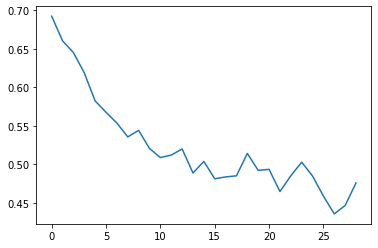

Epoch 1/100
25/25 - 11s - loss: 0.6899 - accuracy: 0.5539 - auc_1: 0.5734 - precision_1: 0.5500 - recall_1: 0.5359 - f1_score: 0.6616 - val_loss: 0.6863 - val_accuracy: 0.5381 - val_auc_1: 0.6231 - val_precision_1: 0.5145 - val_recall_1: 0.9219 - val_f1_score: 0.6553 - 11s/epoch - 441ms/step
Epoch 2/100
25/25 - 4s - loss: 0.6579 - accuracy: 0.6020 - auc_1: 0.6466 - precision_1: 0.5969 - recall_1: 0.6000 - f1_score: 0.6616 - val_loss: 0.6828 - val_accuracy: 0.5457 - val_auc_1: 0.6015 - val_precision_1: 0.5272 - val_recall_1: 0.6562 - val_f1_score: 0.6553 - 4s/epoch - 168ms/step
Epoch 3/100
25/25 - 4s - loss: 0.6278 - accuracy: 0.6477 - auc_1: 0.6999 - precision_1: 0.6481 - recall_1: 0.6282 - f1_score: 0.6616 - val_loss: 0.6827 - val_accuracy: 0.5635 - val_auc_1: 0.6097 - val_precision_1: 0.5379 - val_recall_1: 0.7396 - val_f1_score: 0.6553 - 4s/epoch - 167ms/step
Epoch 4/100
25/25 - 4s - loss: 0.6027 - accuracy: 0.6692 - auc_1: 0.7348 - precision_1: 0.6608 - recall_1: 0.6795 - f1_score:

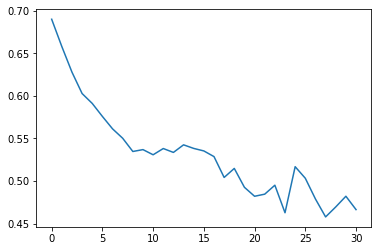

Epoch 1/100
25/25 - 11s - loss: 0.6743 - accuracy: 0.5817 - auc_2: 0.6154 - precision_2: 0.5796 - recall_2: 0.5039 - f1_score: 0.6536 - val_loss: 0.6846 - val_accuracy: 0.5838 - val_auc_2: 0.6122 - val_precision_2: 0.5686 - val_recall_2: 0.7286 - val_f1_score: 0.6712 - 11s/epoch - 458ms/step
Epoch 2/100
25/25 - 6s - loss: 0.6296 - accuracy: 0.6679 - auc_2: 0.7053 - precision_2: 0.6649 - recall_2: 0.6371 - f1_score: 0.6536 - val_loss: 0.7188 - val_accuracy: 0.5076 - val_auc_2: 0.5767 - val_precision_2: 0.5758 - val_recall_2: 0.0955 - val_f1_score: 0.6712 - 6s/epoch - 232ms/step
Epoch 3/100
25/25 - 5s - loss: 0.6059 - accuracy: 0.6527 - auc_2: 0.7308 - precision_2: 0.6453 - recall_2: 0.6319 - f1_score: 0.6536 - val_loss: 0.6920 - val_accuracy: 0.5508 - val_auc_2: 0.5800 - val_precision_2: 0.5932 - val_recall_2: 0.3518 - val_f1_score: 0.6712 - 5s/epoch - 187ms/step
Epoch 4/100
25/25 - 5s - loss: 0.5781 - accuracy: 0.7047 - auc_2: 0.7701 - precision_2: 0.7016 - recall_2: 0.6815 - f1_score:

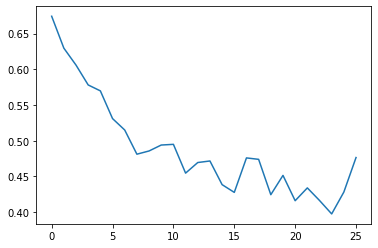

In [6]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_body_model.save(model_path / 'body_binary_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body CNN-BiLSTM')

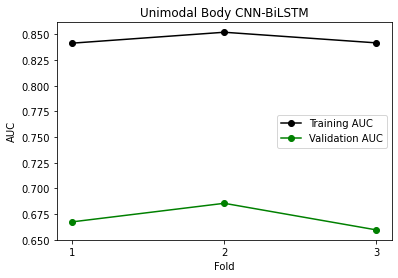

In [7]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body CNN-BiLSTM")

#### Training performance and variance

In [8]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.7434478799502054,
 'ROC/AUC': 0.8450603683789571,
 'Precision': 0.7401402195294698,
 'Recall': 0.7389427026112875,
 'F1-score': 0.6594784061113993}

In [9]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 6.29561835323342e-05,
 'ROC/AUC': 2.450900909265228e-05,
 'Precision': 0.00031405347266478937,
 'Recall': 0.0007532622768767144,
 'F1-score': 1.7853665270529797e-05}

#### Validation performance and variance

In [10]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.6348326007525126,
 'ROC/AUC': 0.6708008845647176,
 'Precision': 0.6079059839248657,
 'Recall': 0.736244817574819,
 'F1-score': 0.6594435969988505}

In [11]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 2.546534991488948e-05,
 'ROC/AUC': 0.00011786747969782457,
 'Precision': 0.0004235990759321832,
 'Recall': 0.0023261857684089035,
 'F1-score': 7.062083764076812e-05}

#### Predictions and performance on test set

In [12]:
cnnlstm_binary_body_model = load_model(model_path / 'body_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 72ms/step - loss: 0.6289 - accuracy: 0.6934 - auc_1: 0.7014 - precision_1: 0.9171 - recall_1: 0.7064 - f1_score: 0.9234
Accuracy: 69.34% 
ROC/AUC: 0.70 
Precision: 0.92 
Recall: 0.71 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

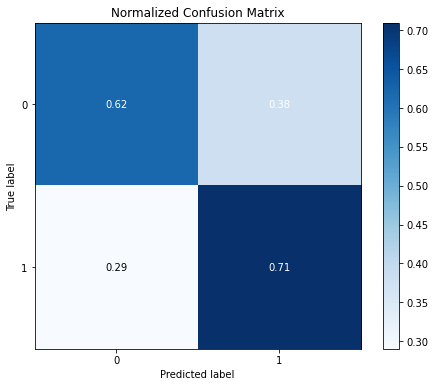

In [13]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

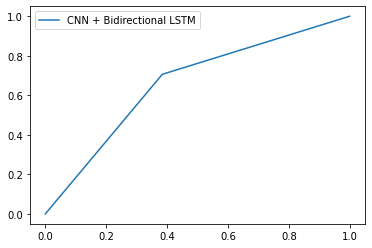

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

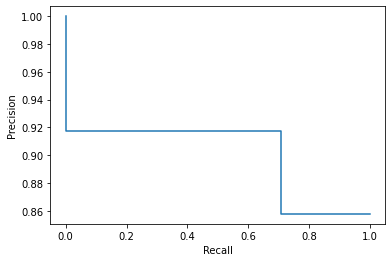

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 1.2 RCNN

Epoch 1/100
25/25 - 3s - loss: 0.7972 - accuracy: 0.4886 - auc_3: 0.5033 - precision_3: 0.4839 - recall_3: 0.4604 - f1_score: 0.6633 - val_loss: 0.6990 - val_accuracy: 0.4937 - val_auc_3: 0.5808 - val_precision_3: 0.4873 - val_recall_3: 0.9005 - val_f1_score: 0.6519 - 3s/epoch - 111ms/step
Epoch 2/100
25/25 - 1s - loss: 0.6961 - accuracy: 0.5406 - auc_3: 0.5429 - precision_3: 0.5362 - recall_3: 0.5499 - f1_score: 0.6633 - val_loss: 0.7229 - val_accuracy: 0.5165 - val_auc_3: 0.6082 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.6519 - 694ms/epoch - 28ms/step
Epoch 3/100
25/25 - 1s - loss: 0.6770 - accuracy: 0.5584 - auc_3: 0.6014 - precision_3: 0.5592 - recall_3: 0.5192 - f1_score: 0.6633 - val_loss: 0.6948 - val_accuracy: 0.5215 - val_auc_3: 0.6421 - val_precision_3: 1.0000 - val_recall_3: 0.0105 - val_f1_score: 0.6519 - 736ms/epoch - 29ms/step
Epoch 4/100
25/25 - 1s - loss: 0.6758 - accuracy: 0.5888 - auc_3: 0.6095 - precision_3: 0.5954 - recall_3: 0.5345 -

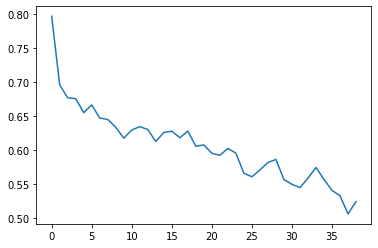

Epoch 1/100
25/25 - 3s - loss: 0.8116 - accuracy: 0.5437 - auc_4: 0.5553 - precision_4: 0.5377 - recall_4: 0.5487 - f1_score: 0.6616 - val_loss: 0.7097 - val_accuracy: 0.5127 - val_auc_4: 0.6097 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.6553 - 3s/epoch - 111ms/step
Epoch 2/100
25/25 - 1s - loss: 0.6660 - accuracy: 0.5982 - auc_4: 0.6248 - precision_4: 0.6052 - recall_4: 0.5385 - f1_score: 0.6616 - val_loss: 0.7092 - val_accuracy: 0.5127 - val_auc_4: 0.6491 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.6553 - 748ms/epoch - 30ms/step
Epoch 3/100
25/25 - 1s - loss: 0.6337 - accuracy: 0.6324 - auc_4: 0.6891 - precision_4: 0.6453 - recall_4: 0.5692 - f1_score: 0.6616 - val_loss: 0.6623 - val_accuracy: 0.6091 - val_auc_4: 0.7020 - val_precision_4: 0.5617 - val_recall_4: 0.9010 - val_f1_score: 0.6553 - 727ms/epoch - 29ms/step
Epoch 4/100
25/25 - 1s - loss: 0.6611 - accuracy: 0.6160 - auc_4: 0.6441 - precision_4: 0.6306 - recall_4: 

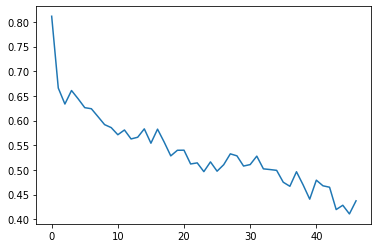

Epoch 1/100
25/25 - 3s - loss: 1.1672 - accuracy: 0.4994 - auc_5: 0.5025 - precision_5: 0.4808 - recall_5: 0.3916 - f1_score: 0.6536 - val_loss: 0.6935 - val_accuracy: 0.4949 - val_auc_5: 0.5227 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.6712 - 3s/epoch - 108ms/step
Epoch 2/100
25/25 - 1s - loss: 0.6930 - accuracy: 0.5222 - auc_5: 0.5386 - precision_5: 0.5091 - recall_5: 0.4360 - f1_score: 0.6536 - val_loss: 0.6919 - val_accuracy: 0.5051 - val_auc_5: 0.6030 - val_precision_5: 0.5051 - val_recall_5: 1.0000 - val_f1_score: 0.6712 - 729ms/epoch - 29ms/step
Epoch 3/100
25/25 - 1s - loss: 0.6717 - accuracy: 0.5805 - auc_5: 0.6142 - precision_5: 0.5739 - recall_5: 0.5274 - f1_score: 0.6536 - val_loss: 0.6782 - val_accuracy: 0.5964 - val_auc_5: 0.6185 - val_precision_5: 0.6389 - val_recall_5: 0.4623 - val_f1_score: 0.6712 - 731ms/epoch - 29ms/step
Epoch 4/100
25/25 - 1s - loss: 0.6626 - accuracy: 0.6147 - auc_5: 0.6405 - precision_5: 0.6165 - recall_5: 0.5457 -

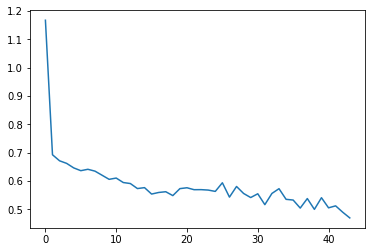

In [16]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_body_model.save(model_path / 'body_binary_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body RCNN')

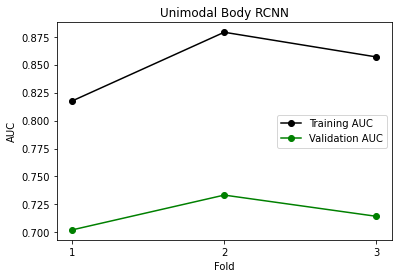

In [17]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body RCNN")

#### Training performance

In [18]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.7776700059572855,
 'ROC/AUC': 0.8511022329330444,
 'Precision': 0.7837886412938436,
 'Recall': 0.7568695545196533,
 'F1-score': 0.6594784061113993}

In [19]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.0006542238645350393,
 'ROC/AUC': 0.0006468314889597574,
 'Precision': 0.0006420592323321569,
 'Recall': 0.0007372892746554763,
 'F1-score': 1.7853665270529797e-05}

#### Validation performance

In [9]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.6660587906837463,
 'ROC/AUC': 0.7407361388206481,
 'Precision': 0.7061899900436401,
 'Recall': 0.5951105237007142,
 'F1-score': 0.6594276666641236}

In [20]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 0.00016981144906935697,
 'ROC/AUC': 0.0001642566777333185,
 'Precision': 0.0018597555076248623,
 'Recall': 0.02461564812288132,
 'F1-score': 7.062083764076812e-05}

#### Predictions and performance on test set

In [21]:
rcnn_binary_body_model = load_model(model_path / 'body_binary_rcnn.h5')
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 8ms/step - loss: 0.9789 - accuracy: 0.4343 - auc_4: 0.6004 - precision_4: 0.9167 - recall_4: 0.3745 - f1_score: 0.9234
Accuracy: 43.43% 
ROC/AUC: 0.60 
Precision: 0.92 
Recall: 0.37 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

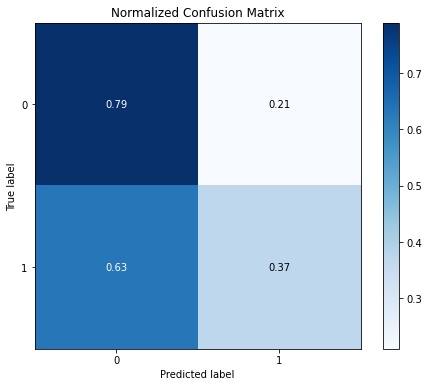

In [22]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

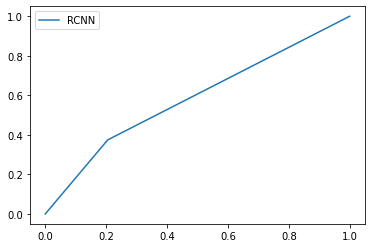

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

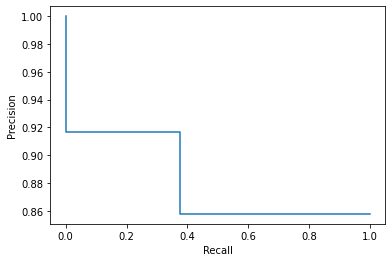

In [24]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 2. Unimodal Face (Facial Expression + Head Pose)

In [25]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [26]:
jitter_X = jitter(X, sigma=0.03)
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
add_y = np.concatenate((y[0:200], y[0:200]), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(1152, 1, 350, 25)

### 2.1 CNN + BiLSTM

Epoch 1/100
24/24 - 20s - loss: 0.6717 - accuracy: 0.5859 - auc_6: 0.6272 - precision_6: 0.5921 - recall_6: 0.5457 - f1_score: 0.6655 - val_loss: 0.6879 - val_accuracy: 0.5625 - val_auc_6: 0.5753 - val_precision_6: 0.5920 - val_recall_6: 0.3874 - val_f1_score: 0.6643 - 20s/epoch - 832ms/step
Epoch 2/100
24/24 - 6s - loss: 0.6479 - accuracy: 0.6419 - auc_6: 0.6743 - precision_6: 0.6484 - recall_6: 0.6162 - f1_score: 0.6655 - val_loss: 0.6948 - val_accuracy: 0.5260 - val_auc_6: 0.5512 - val_precision_6: 0.5354 - val_recall_6: 0.3560 - val_f1_score: 0.6643 - 6s/epoch - 262ms/step
Epoch 3/100
24/24 - 5s - loss: 0.6336 - accuracy: 0.6576 - auc_6: 0.6962 - precision_6: 0.6685 - recall_6: 0.6214 - f1_score: 0.6655 - val_loss: 0.6828 - val_accuracy: 0.5469 - val_auc_6: 0.6000 - val_precision_6: 0.5316 - val_recall_6: 0.7487 - val_f1_score: 0.6643 - 5s/epoch - 215ms/step
Epoch 4/100
24/24 - 5s - loss: 0.6242 - accuracy: 0.6719 - auc_6: 0.7109 - precision_6: 0.6814 - recall_6: 0.6423 - f1_score:

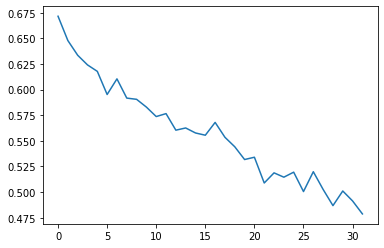

Epoch 1/100
24/24 - 11s - loss: 0.6806 - accuracy: 0.5664 - auc_7: 0.5959 - precision_7: 0.5590 - recall_7: 0.5307 - f1_score: 0.6562 - val_loss: 0.6888 - val_accuracy: 0.5156 - val_auc_7: 0.6285 - val_precision_7: 0.5170 - val_recall_7: 0.9950 - val_f1_score: 0.6827 - 11s/epoch - 468ms/step
Epoch 2/100
24/24 - 5s - loss: 0.6553 - accuracy: 0.6159 - auc_7: 0.6585 - precision_7: 0.5990 - recall_7: 0.6453 - f1_score: 0.6562 - val_loss: 0.6784 - val_accuracy: 0.5807 - val_auc_7: 0.6189 - val_precision_7: 0.6267 - val_recall_7: 0.4724 - val_f1_score: 0.6827 - 5s/epoch - 212ms/step
Epoch 3/100
24/24 - 5s - loss: 0.6421 - accuracy: 0.6263 - auc_7: 0.6809 - precision_7: 0.6229 - recall_7: 0.5947 - f1_score: 0.6562 - val_loss: 0.6698 - val_accuracy: 0.6042 - val_auc_7: 0.6409 - val_precision_7: 0.5951 - val_recall_7: 0.7387 - val_f1_score: 0.6827 - 5s/epoch - 211ms/step
Epoch 4/100
24/24 - 5s - loss: 0.6210 - accuracy: 0.6758 - auc_7: 0.7180 - precision_7: 0.6694 - recall_7: 0.6640 - f1_score:

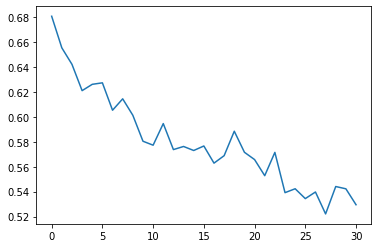

Epoch 1/100
24/24 - 12s - loss: 0.6896 - accuracy: 0.5326 - auc_8: 0.5657 - precision_8: 0.5390 - recall_8: 0.5487 - f1_score: 0.6736 - val_loss: 0.6866 - val_accuracy: 0.5521 - val_auc_8: 0.5851 - val_precision_8: 0.5270 - val_recall_8: 0.6359 - val_f1_score: 0.6479 - 12s/epoch - 479ms/step
Epoch 2/100
24/24 - 5s - loss: 0.6644 - accuracy: 0.5977 - auc_8: 0.6362 - precision_8: 0.5985 - recall_8: 0.6308 - f1_score: 0.6736 - val_loss: 0.6811 - val_accuracy: 0.5599 - val_auc_8: 0.6364 - val_precision_8: 0.5265 - val_recall_8: 0.8098 - val_f1_score: 0.6479 - 5s/epoch - 220ms/step
Epoch 3/100
24/24 - 5s - loss: 0.6619 - accuracy: 0.6107 - auc_8: 0.6465 - precision_8: 0.6046 - recall_8: 0.6744 - f1_score: 0.6736 - val_loss: 0.6756 - val_accuracy: 0.5625 - val_auc_8: 0.6332 - val_precision_8: 0.6111 - val_recall_8: 0.2391 - val_f1_score: 0.6479 - 5s/epoch - 213ms/step
Epoch 4/100
24/24 - 5s - loss: 0.6415 - accuracy: 0.6172 - auc_8: 0.6776 - precision_8: 0.6218 - recall_8: 0.6282 - f1_score:

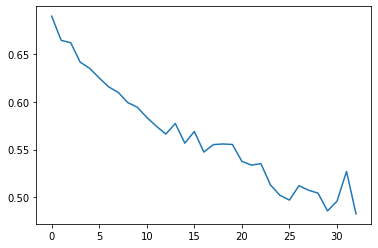

In [27]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_face_model.save(model_path / 'face_binary_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face CNN-BiLSTM')

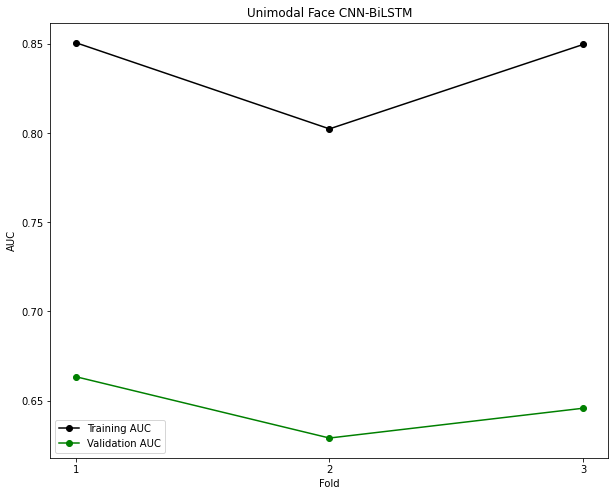

In [29]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face CNN-BiLSTM")

#### Training performance

In [30]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.7534722089767456,
 'ROC/AUC': 0.8343492746353149,
 'Precision': 0.7635280887285868,
 'Recall': 0.7303235530853271,
 'F1-score': 0.6650837858517965}

In [31]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.0002671226939578257,
 'ROC/AUC': 0.0005092941478324065,
 'Precision': 0.00013807996790483735,
 'Recall': 0.001409870988519894,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [32]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5972222089767456,
 'ROC/AUC': 0.6459897955258688,
 'Precision': 0.6008509397506714,
 'Recall': 0.5837181011835734,
 'F1-score': 0.664970318476359}

In [33]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.00023660558149411295,
 'ROC/AUC': 0.00019750463483189957,
 'Precision': 0.0004944935449581559,
 'Recall': 0.002517974384991659,
 'F1-score': 0.00020189955481065959}

#### Predictions and performance on test set

In [34]:
cnnlstm_binary_face_model = load_model(model_path / 'face_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 59ms/step - loss: 0.6774 - accuracy: 0.5261 - auc_6: 0.6386 - precision_6: 0.9194 - recall_6: 0.4935 - f1_score: 0.9259
Accuracy: 52.61% 
ROC/AUC: 0.64 
Precision: 0.92 
Recall: 0.49 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

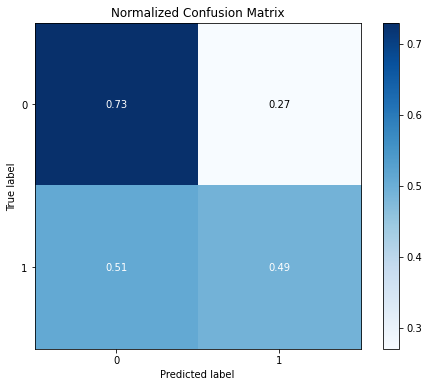

In [35]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

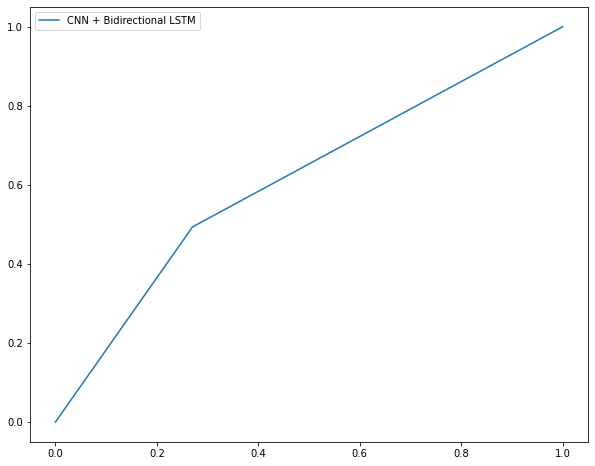

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

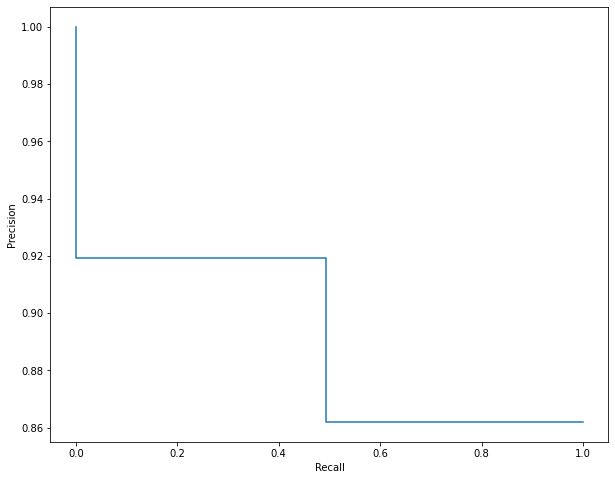

In [37]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 2.2 RCNN

Epoch 1/100
24/24 - 3s - loss: 0.7871 - accuracy: 0.5404 - auc_9: 0.5704 - precision_9: 0.5381 - recall_9: 0.5535 - f1_score: 0.6655 - val_loss: 0.7161 - val_accuracy: 0.4974 - val_auc_9: 0.5547 - val_precision_9: 0.4974 - val_recall_9: 1.0000 - val_f1_score: 0.6643 - 3s/epoch - 107ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6612 - accuracy: 0.6081 - auc_9: 0.6483 - precision_9: 0.6062 - recall_9: 0.6110 - f1_score: 0.6655 - val_loss: 0.6958 - val_accuracy: 0.5078 - val_auc_9: 0.5941 - val_precision_9: 0.5026 - val_recall_9: 1.0000 - val_f1_score: 0.6643 - 693ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6438 - accuracy: 0.6263 - auc_9: 0.6761 - precision_9: 0.6212 - recall_9: 0.6423 - f1_score: 0.6655 - val_loss: 0.6972 - val_accuracy: 0.4844 - val_auc_9: 0.5893 - val_precision_9: 0.4222 - val_recall_9: 0.0995 - val_f1_score: 0.6643 - 642ms/epoch - 27ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6363 - accuracy: 0.6354 - auc_9: 0.6869 - precision_9: 0.6331 - recall_9: 0.6397 - f1_scor

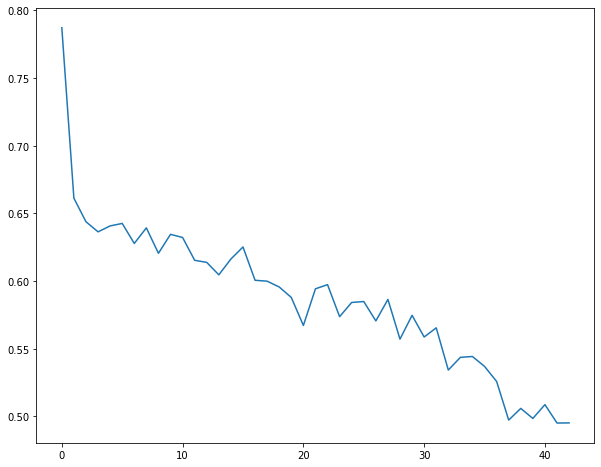

Epoch 1/100
24/24 - 3s - loss: 0.7413 - accuracy: 0.5794 - auc_10: 0.5899 - precision_10: 0.5670 - recall_10: 0.5867 - f1_score: 0.6562 - val_loss: 0.6785 - val_accuracy: 0.5833 - val_auc_10: 0.6490 - val_precision_10: 0.6822 - val_recall_10: 0.3668 - val_f1_score: 0.6827 - 3s/epoch - 106ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6642 - accuracy: 0.6003 - auc_10: 0.6381 - precision_10: 0.6018 - recall_10: 0.5360 - f1_score: 0.6562 - val_loss: 0.6755 - val_accuracy: 0.6276 - val_auc_10: 0.6366 - val_precision_10: 0.6842 - val_recall_10: 0.5226 - val_f1_score: 0.6827 - 699ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6747 - accuracy: 0.6120 - auc_10: 0.6249 - precision_10: 0.6097 - recall_10: 0.5707 - f1_score: 0.6562 - val_loss: 0.6757 - val_accuracy: 0.5365 - val_auc_10: 0.6615 - val_precision_10: 0.5288 - val_recall_10: 0.9698 - val_f1_score: 0.6827 - 651ms/epoch - 27ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6508 - accuracy: 0.6250 - auc_10: 0.6641 - precision_10: 0.6130 - recall

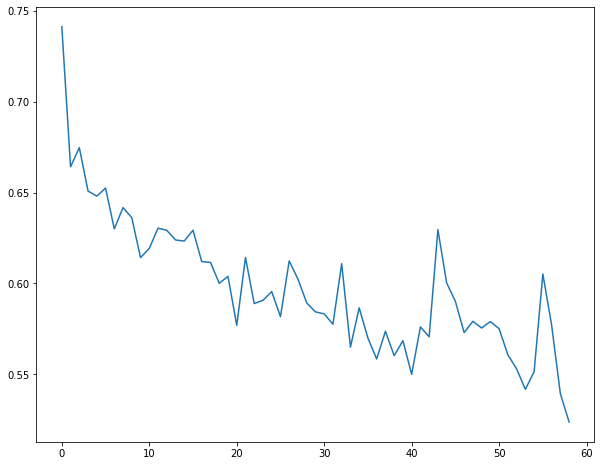

Epoch 1/100
24/24 - 3s - loss: 0.8015 - accuracy: 0.5260 - auc_11: 0.5372 - precision_11: 0.5330 - recall_11: 0.5385 - f1_score: 0.6736 - val_loss: 0.6939 - val_accuracy: 0.4792 - val_auc_11: 0.6535 - val_precision_11: 0.4792 - val_recall_11: 1.0000 - val_f1_score: 0.6479 - 3s/epoch - 121ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6804 - accuracy: 0.5625 - auc_11: 0.5904 - precision_11: 0.5562 - recall_11: 0.6846 - f1_score: 0.6736 - val_loss: 0.6790 - val_accuracy: 0.5938 - val_auc_11: 0.6409 - val_precision_11: 0.6591 - val_recall_11: 0.3152 - val_f1_score: 0.6479 - 688ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6756 - accuracy: 0.5820 - auc_11: 0.6131 - precision_11: 0.5844 - recall_11: 0.6128 - f1_score: 0.6736 - val_loss: 0.7137 - val_accuracy: 0.5208 - val_auc_11: 0.6872 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.6479 - 642ms/epoch - 27ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6782 - accuracy: 0.5703 - auc_11: 0.6112 - precision_11: 0.5777 

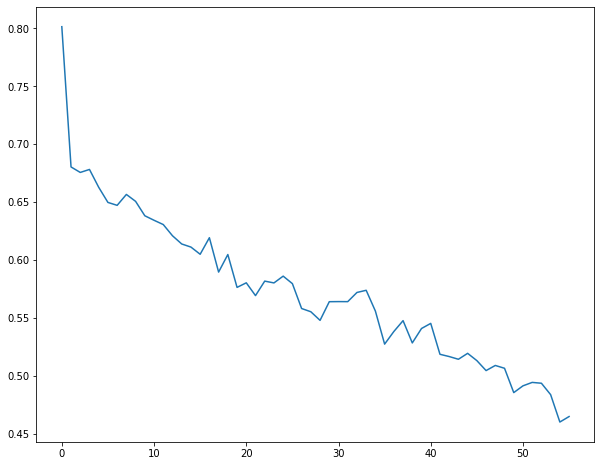

In [38]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_face_model.save(model_path / 'face_binary_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face RCNN')

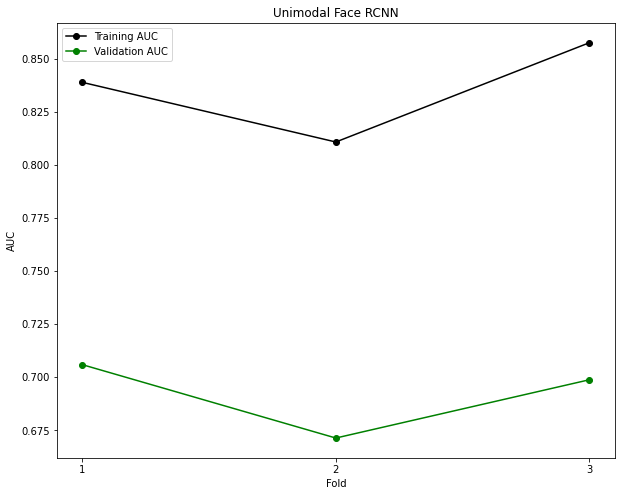

In [39]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face RCNN")

#### Training performance

In [40]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.7521701256434122,
 'ROC/AUC': 0.83577561378479,
 'Precision': 0.73768017689387,
 'Recall': 0.7814473112424215,
 'F1-score': 0.6650837858517965}

In [41]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.0001812215871465936,
 'ROC/AUC': 0.0003698211591848614,
 'Precision': 0.0006517940083396764,
 'Recall': 0.00012206632907505209,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [42]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.640625,
 'ROC/AUC': 0.6920240521430969,
 'Precision': 0.6277442574501038,
 'Recall': 0.6937786340713501,
 'F1-score': 0.664970318476359}

In [43]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 3.164782430313077e-05,
 'ROC/AUC': 0.00022229956710143975,
 'Precision': 0.0001867335408221038,
 'Recall': 0.012161741214429847,
 'F1-score': 0.00020189955481065959}

#### Predictions and performance on test set

In [44]:
rcnn_binary_face_model = load_model(model_path / 'face_binary_rcnn.h5')
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 9ms/step - loss: 0.6981 - accuracy: 0.6231 - auc_9: 0.6223 - precision_9: 0.9062 - recall_9: 0.6277 - f1_score: 0.9259
Accuracy: 62.31% 
ROC/AUC: 0.62 
Precision: 0.91 
Recall: 0.63 
F1 score: 0.93


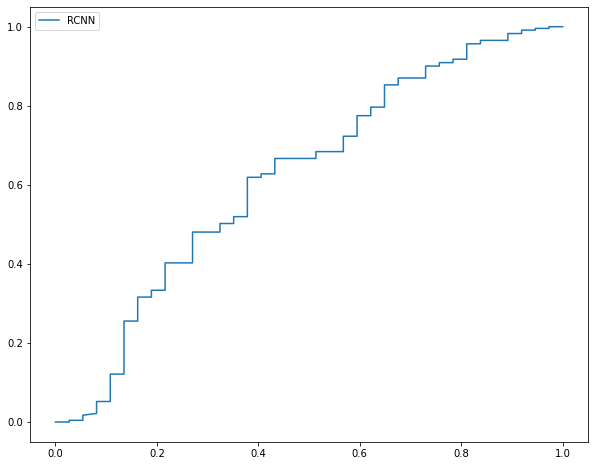

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

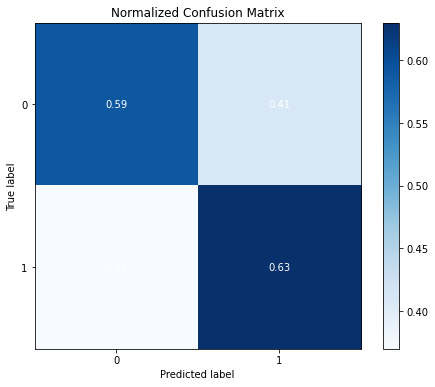

In [46]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

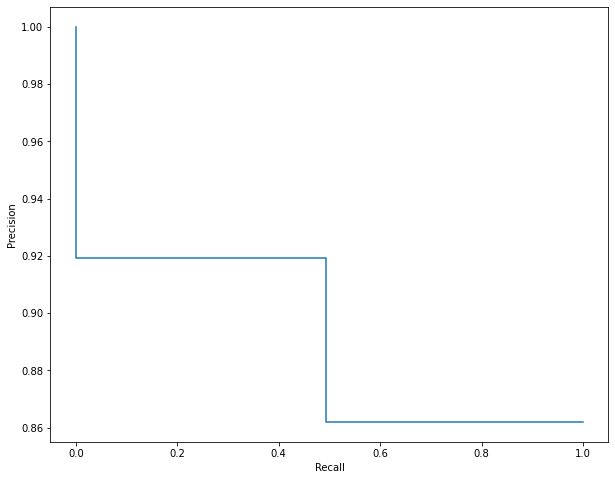

In [47]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp.plot()

## 3. Multimodal Early Fusion

In [48]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 60) (752, 1)
(268, 1, 350, 60) (268, 1)


In [49]:
jitter_X = jitter(X, sigma=0.03)
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
add_y = np.concatenate((y[0:200], y[0:200]), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(1152, 1, 350, 60)

### 3.1 CNN + BiLSTM

Epoch 1/100
24/24 - 12s - loss: 0.6766 - accuracy: 0.5781 - auc_12: 0.6083 - precision_12: 0.5725 - recall_12: 0.6084 - f1_score: 0.6655 - val_loss: 0.6830 - val_accuracy: 0.5729 - val_auc_12: 0.5958 - val_precision_12: 0.5628 - val_recall_12: 0.6335 - val_f1_score: 0.6643 - 12s/epoch - 496ms/step
Epoch 2/100
24/24 - 6s - loss: 0.6212 - accuracy: 0.6745 - auc_12: 0.7157 - precision_12: 0.6626 - recall_12: 0.7076 - f1_score: 0.6655 - val_loss: 0.6708 - val_accuracy: 0.6224 - val_auc_12: 0.6234 - val_precision_12: 0.6386 - val_recall_12: 0.5550 - val_f1_score: 0.6643 - 6s/epoch - 245ms/step
Epoch 3/100
24/24 - 6s - loss: 0.5839 - accuracy: 0.7161 - auc_12: 0.7568 - precision_12: 0.7324 - recall_12: 0.6789 - f1_score: 0.6655 - val_loss: 0.6639 - val_accuracy: 0.6224 - val_auc_12: 0.6517 - val_precision_12: 0.6620 - val_recall_12: 0.4921 - val_f1_score: 0.6643 - 6s/epoch - 235ms/step
Epoch 4/100
24/24 - 6s - loss: 0.5545 - accuracy: 0.7253 - auc_12: 0.7915 - precision_12: 0.7376 - recall_1

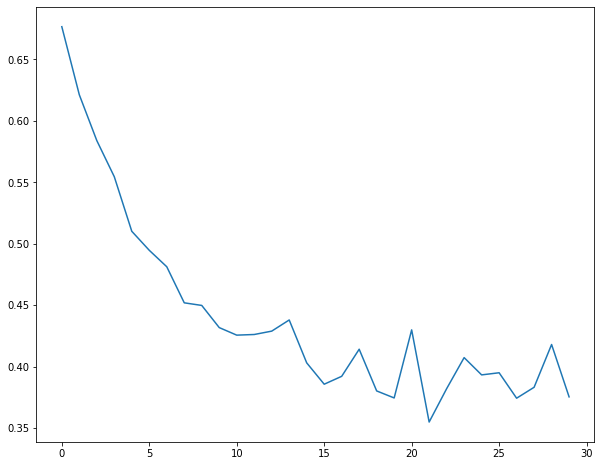

Epoch 1/100
24/24 - 12s - loss: 0.6842 - accuracy: 0.5482 - auc_13: 0.5753 - precision_13: 0.5412 - recall_13: 0.4907 - f1_score: 0.6562 - val_loss: 0.6722 - val_accuracy: 0.6120 - val_auc_13: 0.6495 - val_precision_13: 0.6008 - val_recall_13: 0.7487 - val_f1_score: 0.6827 - 12s/epoch - 488ms/step
Epoch 2/100
24/24 - 6s - loss: 0.6266 - accuracy: 0.6354 - auc_13: 0.7038 - precision_13: 0.6369 - recall_13: 0.5893 - f1_score: 0.6562 - val_loss: 0.6726 - val_accuracy: 0.6042 - val_auc_13: 0.6370 - val_precision_13: 0.5867 - val_recall_13: 0.7990 - val_f1_score: 0.6827 - 6s/epoch - 269ms/step
Epoch 3/100
24/24 - 6s - loss: 0.5907 - accuracy: 0.6836 - auc_13: 0.7524 - precision_13: 0.6746 - recall_13: 0.6800 - f1_score: 0.6562 - val_loss: 0.6678 - val_accuracy: 0.6250 - val_auc_13: 0.6436 - val_precision_13: 0.6730 - val_recall_13: 0.5377 - val_f1_score: 0.6827 - 6s/epoch - 240ms/step
Epoch 4/100
24/24 - 6s - loss: 0.5752 - accuracy: 0.7122 - auc_13: 0.7682 - precision_13: 0.7104 - recall_1

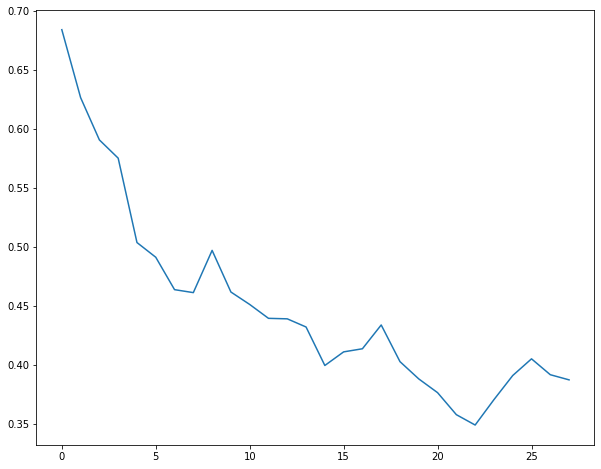

Epoch 1/100
24/24 - 12s - loss: 0.6868 - accuracy: 0.5651 - auc_14: 0.5838 - precision_14: 0.5648 - recall_14: 0.6256 - f1_score: 0.6736 - val_loss: 0.6952 - val_accuracy: 0.5026 - val_auc_14: 0.5814 - val_precision_14: 0.4896 - val_recall_14: 0.8967 - val_f1_score: 0.6479 - 12s/epoch - 480ms/step
Epoch 2/100
24/24 - 6s - loss: 0.6343 - accuracy: 0.6497 - auc_14: 0.6932 - precision_14: 0.6555 - recall_14: 0.6538 - f1_score: 0.6736 - val_loss: 0.6804 - val_accuracy: 0.5651 - val_auc_14: 0.6225 - val_precision_14: 0.5307 - val_recall_14: 0.7989 - val_f1_score: 0.6479 - 6s/epoch - 268ms/step
Epoch 3/100
24/24 - 5s - loss: 0.5987 - accuracy: 0.6680 - auc_14: 0.7394 - precision_14: 0.6839 - recall_14: 0.6436 - f1_score: 0.6736 - val_loss: 0.6944 - val_accuracy: 0.5443 - val_auc_14: 0.6485 - val_precision_14: 0.5140 - val_recall_14: 0.8967 - val_f1_score: 0.6479 - 5s/epoch - 221ms/step
Epoch 4/100
24/24 - 5s - loss: 0.5851 - accuracy: 0.6875 - auc_14: 0.7560 - precision_14: 0.6984 - recall_1

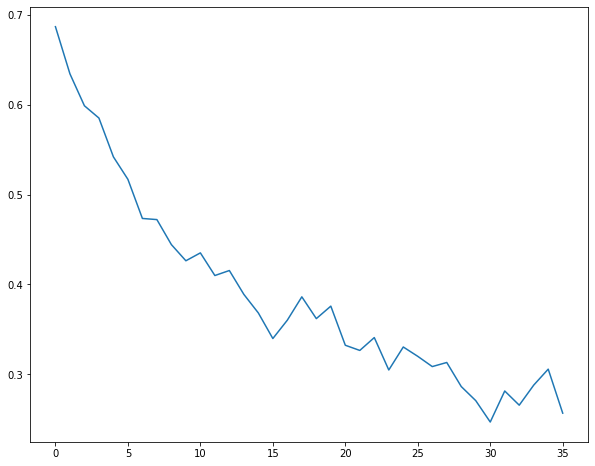

In [50]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_earlyfusion_model.save(model_path / 'early_binary_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion CNN-BiLSTM')

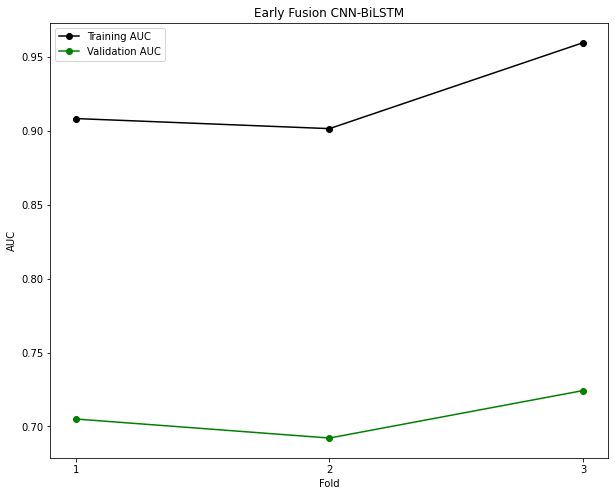

In [51]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion CNN-BiLSTM")

#### Training performance

In [52]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.8402777910232544,
 'ROC/AUC': 0.923313836256663,
 'Precision': 0.8501940170923868,
 'Recall': 0.8223928014437357,
 'F1-score': 0.6650837858517965}

In [53]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0013589734602490466,
 'ROC/AUC': 0.00067455393611324,
 'Precision': 0.0009480676581132584,
 'Recall': 0.0030275910436859343,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [54]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.6588541467984518,
 'ROC/AUC': 0.7071712017059326,
 'Precision': 0.6432455976804098,
 'Recall': 0.704788347085317,
 'F1-score': 0.664970318476359}

In [55]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 5.4253472222222226e-05,
 'ROC/AUC': 0.00017446698191984447,
 'Precision': 0.0001915471337249465,
 'Recall': 0.0007579757568036725,
 'F1-score': 0.00020189955481065959}

#### Predictions and performance on test set

In [56]:
cnnlstm_binary_earlyfusion_model = load_model(model_path / 'early_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 2s 61ms/step - loss: 0.9104 - accuracy: 0.4328 - auc_14: 0.5164 - precision_14: 0.8835 - recall_14: 0.3939 - f1_score: 0.9259
Accuracy: 43.28% 
ROC/AUC: 0.52 
Precision: 0.88 
Recall: 0.39 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

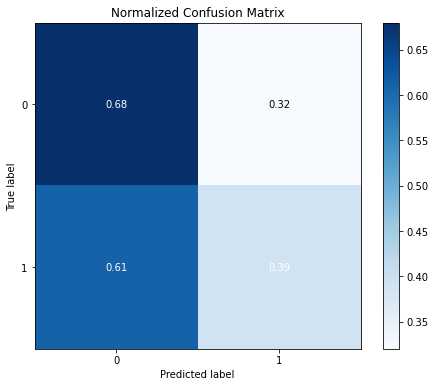

In [57]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

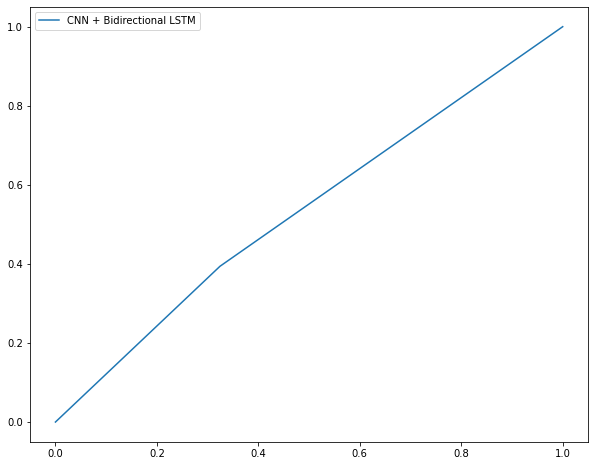

In [58]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

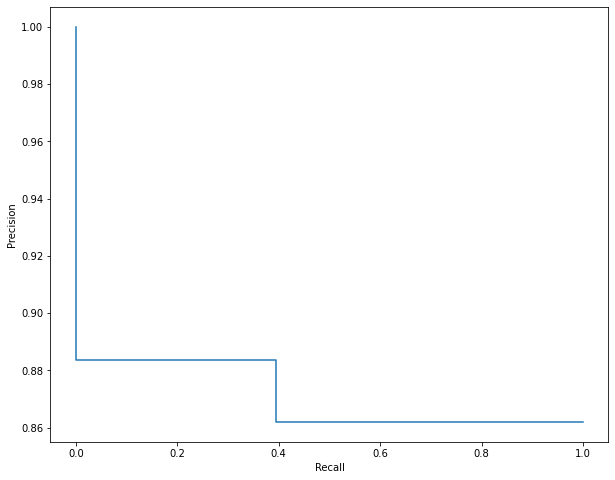

In [59]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 3.2 RCNN

Epoch 1/100
24/24 - 3s - loss: 0.8249 - accuracy: 0.5247 - auc_15: 0.5281 - precision_15: 0.5231 - recall_15: 0.5326 - f1_score: 0.6655 - val_loss: 0.6808 - val_accuracy: 0.5677 - val_auc_15: 0.6247 - val_precision_15: 0.5541 - val_recall_15: 0.6702 - val_f1_score: 0.6643 - 3s/epoch - 110ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6671 - accuracy: 0.5898 - auc_15: 0.6329 - precision_15: 0.5950 - recall_15: 0.5561 - f1_score: 0.6655 - val_loss: 0.6736 - val_accuracy: 0.5938 - val_auc_15: 0.6449 - val_precision_15: 0.5651 - val_recall_15: 0.7958 - val_f1_score: 0.6643 - 715ms/epoch - 30ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6598 - accuracy: 0.6120 - auc_15: 0.6494 - precision_15: 0.6139 - recall_15: 0.5979 - f1_score: 0.6655 - val_loss: 0.6644 - val_accuracy: 0.6042 - val_auc_15: 0.6496 - val_precision_15: 0.5823 - val_recall_15: 0.7225 - val_f1_score: 0.6643 - 740ms/epoch - 31ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6424 - accuracy: 0.6419 - auc_15: 0.6845 - precision_15: 0.6429 - recall

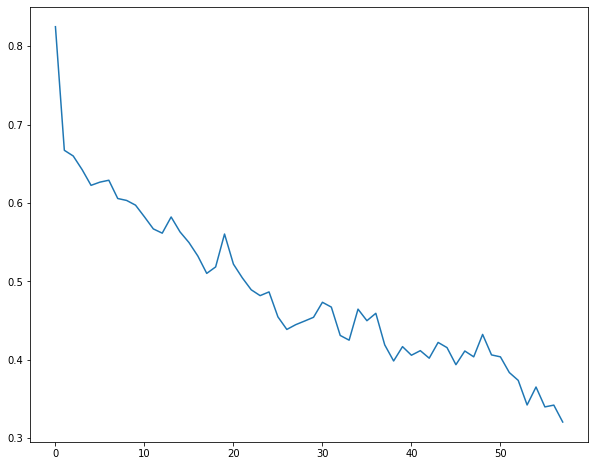

Epoch 1/100
24/24 - 3s - loss: 0.8534 - accuracy: 0.5391 - auc_16: 0.5570 - precision_16: 0.5279 - recall_16: 0.5307 - f1_score: 0.6562 - val_loss: 0.7197 - val_accuracy: 0.4818 - val_auc_16: 0.6060 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.6827 - 3s/epoch - 106ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6811 - accuracy: 0.5534 - auc_16: 0.5987 - precision_16: 0.5452 - recall_16: 0.5147 - f1_score: 0.6562 - val_loss: 0.6789 - val_accuracy: 0.6276 - val_auc_16: 0.6206 - val_precision_16: 0.6069 - val_recall_16: 0.7990 - val_f1_score: 0.6827 - 709ms/epoch - 30ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6689 - accuracy: 0.5977 - auc_16: 0.6310 - precision_16: 0.5873 - recall_16: 0.5920 - f1_score: 0.6562 - val_loss: 0.6898 - val_accuracy: 0.5104 - val_auc_16: 0.5982 - val_precision_16: 0.5753 - val_recall_16: 0.2111 - val_f1_score: 0.6827 - 647ms/epoch - 27ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6477 - accuracy: 0.6172 - auc_16: 0.6715 - precision_16: 0.6098 

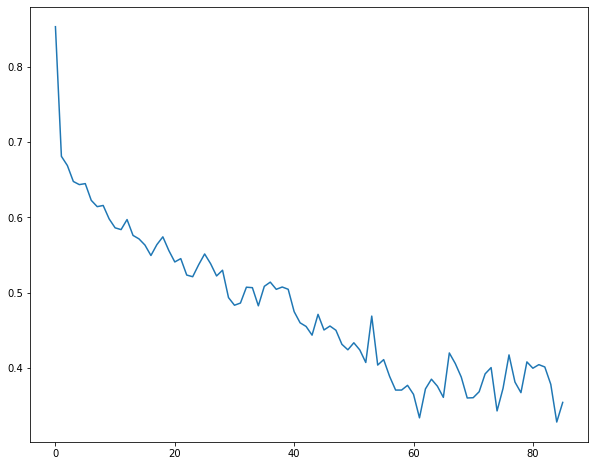

Epoch 1/100
24/24 - 3s - loss: 0.8050 - accuracy: 0.4857 - auc_17: 0.4977 - precision_17: 0.4937 - recall_17: 0.5026 - f1_score: 0.6736 - val_loss: 0.6741 - val_accuracy: 0.6536 - val_auc_17: 0.6752 - val_precision_17: 0.6711 - val_recall_17: 0.5435 - val_f1_score: 0.6479 - 3s/epoch - 114ms/step
Epoch 2/100
24/24 - 1s - loss: 0.6806 - accuracy: 0.5703 - auc_17: 0.5904 - precision_17: 0.5765 - recall_17: 0.5795 - f1_score: 0.6736 - val_loss: 0.6792 - val_accuracy: 0.6146 - val_auc_17: 0.6901 - val_precision_17: 0.5714 - val_recall_17: 0.7826 - val_f1_score: 0.6479 - 738ms/epoch - 31ms/step
Epoch 3/100
24/24 - 1s - loss: 0.6778 - accuracy: 0.5807 - auc_17: 0.6081 - precision_17: 0.5872 - recall_17: 0.5872 - f1_score: 0.6736 - val_loss: 0.6612 - val_accuracy: 0.5990 - val_auc_17: 0.7042 - val_precision_17: 0.5573 - val_recall_17: 0.7935 - val_f1_score: 0.6479 - 736ms/epoch - 31ms/step
Epoch 4/100
24/24 - 1s - loss: 0.6655 - accuracy: 0.5911 - auc_17: 0.6278 - precision_17: 0.5955 - recall

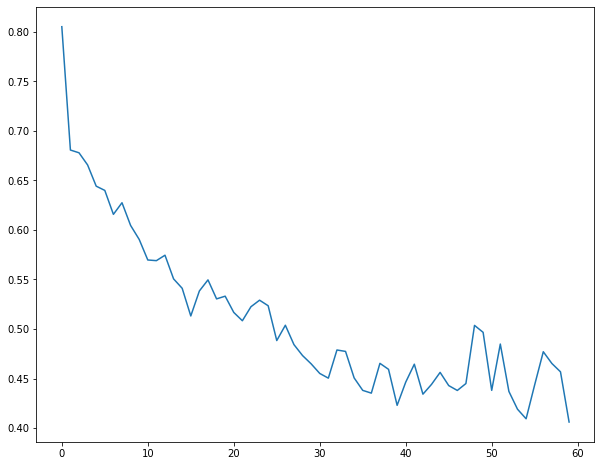

In [60]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_earlyfusion_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_earlyfusion_model.save(model_path / 'early_binary_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion RCNN')

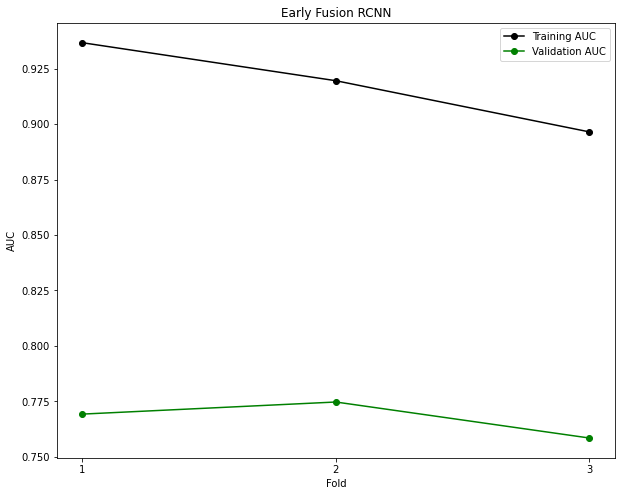

In [61]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion RCNN")

#### Training performance

In [62]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.8381076256434122,
 'ROC/AUC': 0.9175837834676107,
 'Precision': 0.8453372120857239,
 'Recall': 0.8257155617078146,
 'F1-score': 0.6650837858517965}

In [63]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.0007034118264270559,
 'ROC/AUC': 0.0002718433976704028,
 'Precision': 0.00010392980428501157,
 'Recall': 0.002630294283262755,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [64]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.7005208333333334,
 'ROC/AUC': 0.7674222985903422,
 'Precision': 0.6997335950533549,
 'Recall': 0.6990591088930765,
 'F1-score': 0.664970318476359}

In [65]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.0001401551826687195,
 'ROC/AUC': 4.5571298751983446e-05,
 'Precision': 9.256106657160344e-05,
 'Recall': 0.0005902545706848943,
 'F1-score': 0.00020189955481065959}

#### Predictions and performance on test set

In [66]:
rcnn_binary_earlyfusion_model = load_model(model_path / 'early_binary_rcnn.h5')
y_pred = rcnn_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 9ms/step - loss: 0.9795 - accuracy: 0.5112 - auc_16: 0.7026 - precision_16: 0.9310 - recall_16: 0.4675 - f1_score: 0.9259
Accuracy: 51.12% 
ROC/AUC: 0.70 
Precision: 0.93 
Recall: 0.47 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

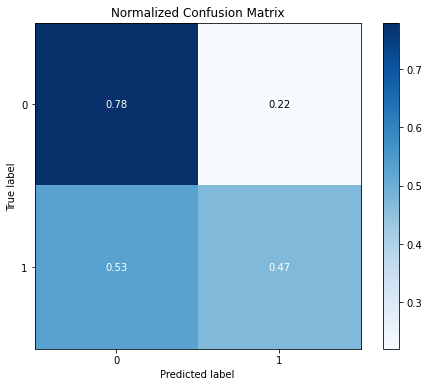

In [67]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

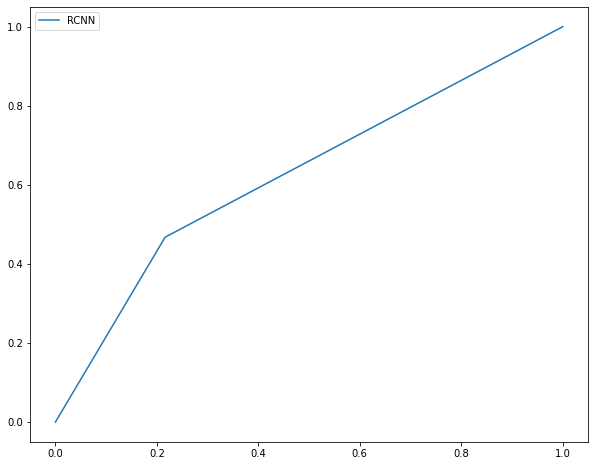

In [68]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

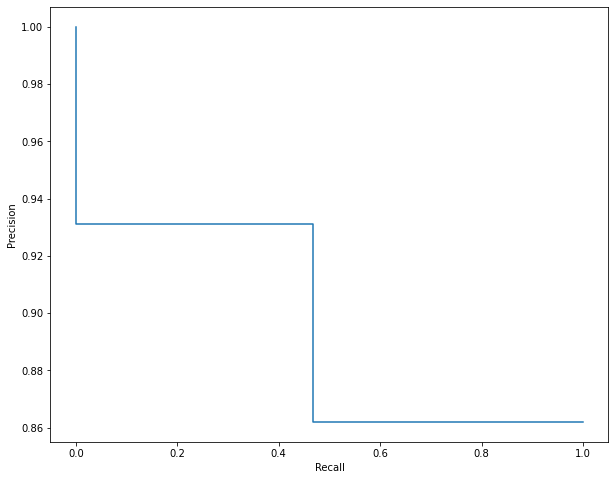

In [69]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 4. Multimodal Late Fusion

In [70]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(752, 1, 350, 35) (752, 1)
(268, 1, 350, 35) (268, 1)


In [71]:
jitter_X = jitter(body_X, sigma=0.03)
reshaped_X = body_X.reshape((body_X.shape[0], body_X.shape[2], body_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
add_y = np.concatenate((body_y[0:200], body_y[0:200]), axis=0)
full_body_X = np.concatenate((augmented_X, body_X), axis=0)
full_y = np.concatenate((add_y, body_y), axis=0)
full_body_X.shape

(1152, 1, 350, 35)

In [72]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [73]:
jitter_X = jitter(face_X, sigma=0.03)
reshaped_X = face_X.reshape((face_X.shape[0], face_X.shape[2], face_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X[0:200], jitter_X[0:200]), axis=0)
full_face_X = np.concatenate((augmented_X, face_X), axis=0)
full_face_X.shape

(1152, 1, 350, 25)

In [74]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
24/24 - 29s - loss: 0.6596 - accuracy: 0.6289 - auc_18: 0.6549 - precision_18: 0.6416 - recall_18: 0.5796 - f1_score: 0.6655 - val_loss: 0.6805 - val_accuracy: 0.5885 - val_auc_18: 0.6143 - val_precision_18: 0.6078 - val_recall_18: 0.4869 - val_f1_score: 0.6643 - 29s/epoch - 1s/step
Epoch 2/100
24/24 - 15s - loss: 0.6064 - accuracy: 0.6849 - auc_18: 0.7369 - precision_18: 0.6776 - recall_18: 0.7023 - f1_score: 0.6655 - val_loss: 0.6947 - val_accuracy: 0.5260 - val_auc_18: 0.5997 - val_precision_18: 0.5692 - val_recall_18: 0.1937 - val_f1_score: 0.6643 - 15s/epoch - 607ms/step
Epoch 3/100
24/24 - 17s - loss: 0.5824 - accuracy: 0.7070 - auc_18: 0.7592 - precision_18: 0.6995 - recall_18: 0.7232 - f1_score: 0.6655 - val_loss: 0.6751 - val_accuracy: 0.5729 - val_auc_18: 0.6410 - val_precision_18: 0.6216 - val_recall_18: 0.3613 - val_f1_score: 0.6643 - 17s/epoch - 693ms/step
Epoch 4/100
24/24 - 13s - loss: 0.5562 - accuracy: 0.7240 - auc_18: 0.7879 - precision_18: 0.7187 - recall

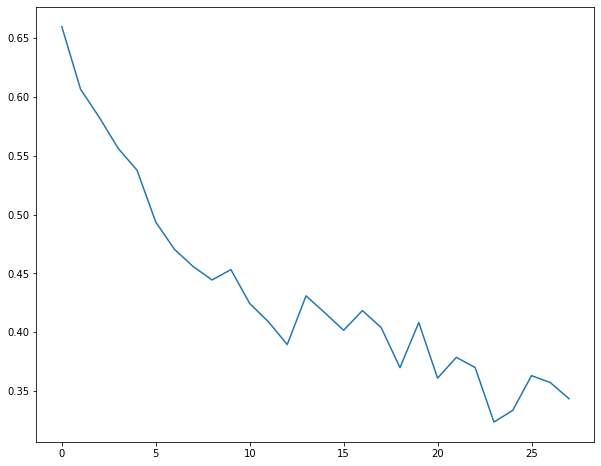

Epoch 1/100
24/24 - 22s - loss: 0.6797 - accuracy: 0.5664 - auc_19: 0.5915 - precision_19: 0.5556 - recall_19: 0.5600 - f1_score: 0.6562 - val_loss: 0.6808 - val_accuracy: 0.5651 - val_auc_19: 0.6128 - val_precision_19: 0.5580 - val_recall_19: 0.7739 - val_f1_score: 0.6827 - 22s/epoch - 897ms/step
Epoch 2/100
24/24 - 10s - loss: 0.6242 - accuracy: 0.6445 - auc_19: 0.7092 - precision_19: 0.6483 - recall_19: 0.5947 - f1_score: 0.6562 - val_loss: 0.7040 - val_accuracy: 0.5208 - val_auc_19: 0.6122 - val_precision_19: 0.5214 - val_recall_19: 0.9196 - val_f1_score: 0.6827 - 10s/epoch - 435ms/step
Epoch 3/100
24/24 - 15s - loss: 0.5991 - accuracy: 0.6849 - auc_19: 0.7420 - precision_19: 0.6745 - recall_19: 0.6853 - f1_score: 0.6562 - val_loss: 0.6749 - val_accuracy: 0.5677 - val_auc_19: 0.6415 - val_precision_19: 0.5567 - val_recall_19: 0.8141 - val_f1_score: 0.6827 - 15s/epoch - 633ms/step
Epoch 4/100
24/24 - 10s - loss: 0.5566 - accuracy: 0.7135 - auc_19: 0.7857 - precision_19: 0.7067 - rec

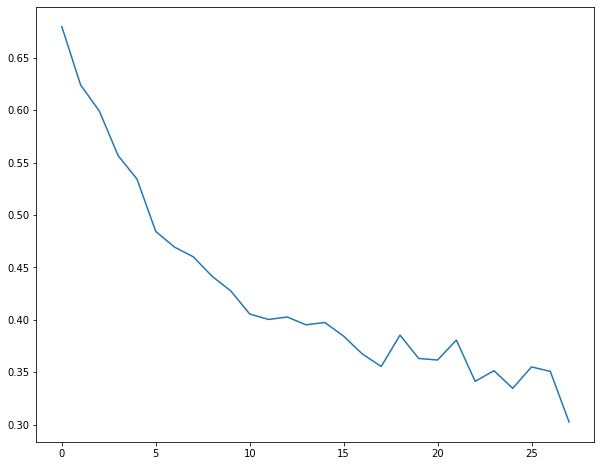

Epoch 1/100
24/24 - 21s - loss: 0.6868 - accuracy: 0.5586 - auc_20: 0.5782 - precision_20: 0.5612 - recall_20: 0.6000 - f1_score: 0.6736 - val_loss: 0.6765 - val_accuracy: 0.6224 - val_auc_20: 0.6416 - val_precision_20: 0.6309 - val_recall_20: 0.5109 - val_f1_score: 0.6479 - 21s/epoch - 885ms/step
Epoch 2/100
24/24 - 11s - loss: 0.6135 - accuracy: 0.6654 - auc_20: 0.7216 - precision_20: 0.6718 - recall_20: 0.6667 - f1_score: 0.6736 - val_loss: 0.6984 - val_accuracy: 0.5130 - val_auc_20: 0.5600 - val_precision_20: 0.4950 - val_recall_20: 0.8043 - val_f1_score: 0.6479 - 11s/epoch - 460ms/step
Epoch 3/100
24/24 - 12s - loss: 0.5874 - accuracy: 0.7070 - auc_20: 0.7591 - precision_20: 0.7132 - recall_20: 0.7077 - f1_score: 0.6736 - val_loss: 0.7584 - val_accuracy: 0.4583 - val_auc_20: 0.5839 - val_precision_20: 0.4657 - val_recall_20: 0.8859 - val_f1_score: 0.6479 - 12s/epoch - 516ms/step
Epoch 4/100
24/24 - 10s - loss: 0.5631 - accuracy: 0.7083 - auc_20: 0.7823 - precision_20: 0.7065 - rec

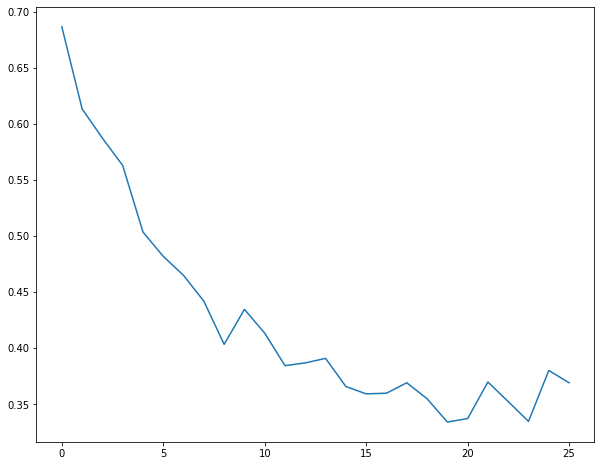

In [75]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs)
    history = cnnlstm_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_latefusion_model.save(model_path / 'late_binary_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion CNN-BiLSTM')

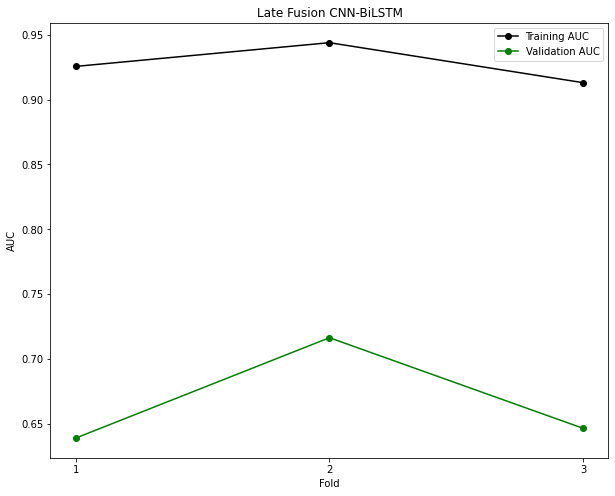

In [76]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion CNN-BiLSTM")

#### Training performance

In [77]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.8441840410232544,
 'ROC/AUC': 0.9275563955307007,
 'Precision': 0.8508914311726888,
 'Recall': 0.8345714012781779,
 'F1-score': 0.6650837858517965}

In [78]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.00030781310856535055,
 'ROC/AUC': 0.00016048669074090563,
 'Precision': 0.0005231371324927952,
 'Recall': 2.362613344154675e-05,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [79]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.6371527910232544,
 'ROC/AUC': 0.6671830217043558,
 'Precision': 0.6159214774767557,
 'Recall': 0.7320989569028219,
 'F1-score': 0.664970318476359}

In [80]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.0013081120718041461,
 'ROC/AUC': 0.0012148495883018819,
 'Precision': 0.0017644476043333019,
 'Recall': 0.0027947504543995986,
 'F1-score': 0.00020189955481065959}

#### Performance and predictions on test set

In [81]:
cnnlstm_binary_latefusion_model = load_model(model_path / 'late_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 3s 133ms/step - loss: 0.5453 - accuracy: 0.8396 - auc_19: 0.6794 - precision_19: 0.8917 - recall_19: 0.9264 - f1_score: 0.9259
Accuracy: 83.96% 
ROC/AUC: 0.68 
Precision: 0.89 
Recall: 0.93 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

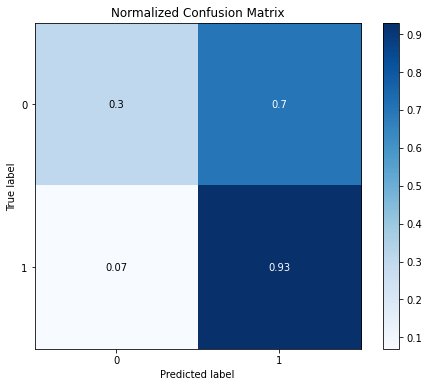

In [82]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

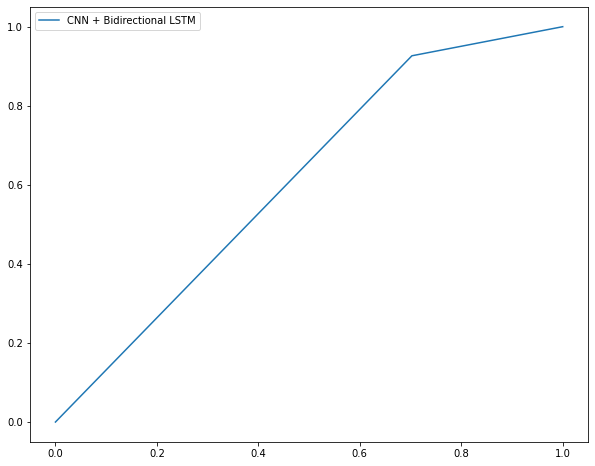

In [83]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

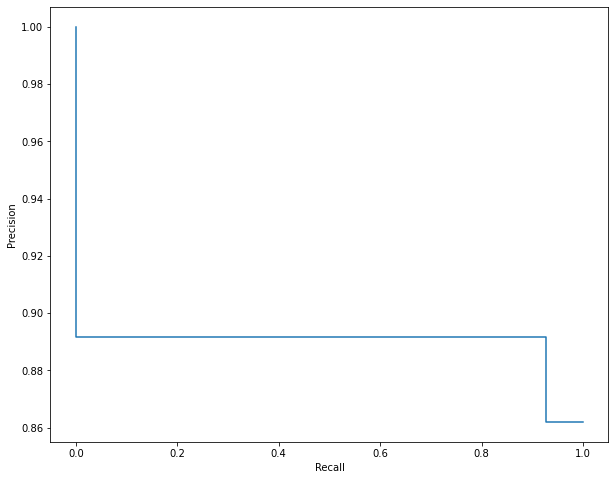

In [84]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.2 RCNN (Concatenation)

Epoch 1/100
24/24 - 3s - loss: 0.8183 - accuracy: 0.5664 - auc_21: 0.5969 - precision_21: 0.5687 - recall_21: 0.5405 - f1_score: 0.6655 - val_loss: 1.1588 - val_accuracy: 0.4974 - val_auc_21: 0.5912 - val_precision_21: 0.4974 - val_recall_21: 1.0000 - val_f1_score: 0.6643 - 3s/epoch - 108ms/step
Epoch 2/100
24/24 - 1s - loss: 0.8010 - accuracy: 0.6094 - auc_21: 0.6298 - precision_21: 0.6113 - recall_21: 0.5953 - f1_score: 0.6655 - val_loss: 1.1452 - val_accuracy: 0.4974 - val_auc_21: 0.6581 - val_precision_21: 0.4974 - val_recall_21: 1.0000 - val_f1_score: 0.6643 - 751ms/epoch - 31ms/step
Epoch 3/100
24/24 - 1s - loss: 0.8020 - accuracy: 0.5951 - auc_21: 0.6388 - precision_21: 0.5914 - recall_21: 0.6084 - f1_score: 0.6655 - val_loss: 0.8725 - val_accuracy: 0.5026 - val_auc_21: 0.6661 - val_precision_21: 0.5000 - val_recall_21: 1.0000 - val_f1_score: 0.6643 - 703ms/epoch - 29ms/step
Epoch 4/100
24/24 - 1s - loss: 0.7210 - accuracy: 0.6276 - auc_21: 0.6742 - precision_21: 0.6286 - recall

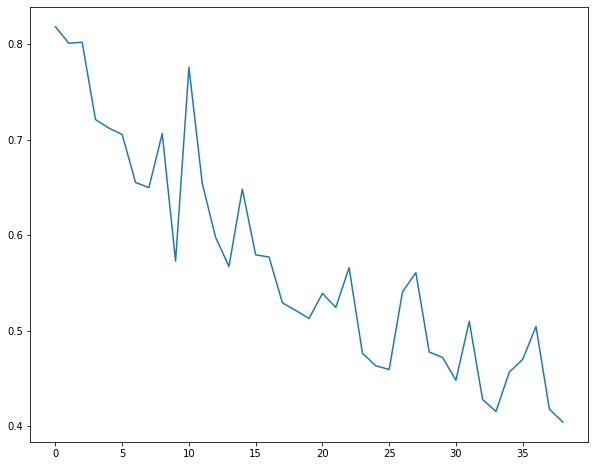

Epoch 1/100
24/24 - 3s - loss: 0.8883 - accuracy: 0.5560 - auc_22: 0.5623 - precision_22: 0.5450 - recall_22: 0.5493 - f1_score: 0.6562 - val_loss: 0.7534 - val_accuracy: 0.4792 - val_auc_22: 0.5986 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.6827 - 3s/epoch - 108ms/step
Epoch 2/100
24/24 - 1s - loss: 0.7941 - accuracy: 0.5833 - auc_22: 0.6121 - precision_22: 0.5793 - recall_22: 0.5360 - f1_score: 0.6562 - val_loss: 0.7044 - val_accuracy: 0.5703 - val_auc_22: 0.6102 - val_precision_22: 0.5649 - val_recall_22: 0.7437 - val_f1_score: 0.6827 - 711ms/epoch - 30ms/step
Epoch 3/100
24/24 - 1s - loss: 0.8650 - accuracy: 0.5547 - auc_22: 0.5856 - precision_22: 0.5476 - recall_22: 0.5067 - f1_score: 0.6562 - val_loss: 0.9536 - val_accuracy: 0.5182 - val_auc_22: 0.6660 - val_precision_22: 0.5182 - val_recall_22: 1.0000 - val_f1_score: 0.6827 - 684ms/epoch - 28ms/step
Epoch 4/100
24/24 - 1s - loss: 0.7338 - accuracy: 0.6263 - auc_22: 0.6610 - precision_22: 0.6196 

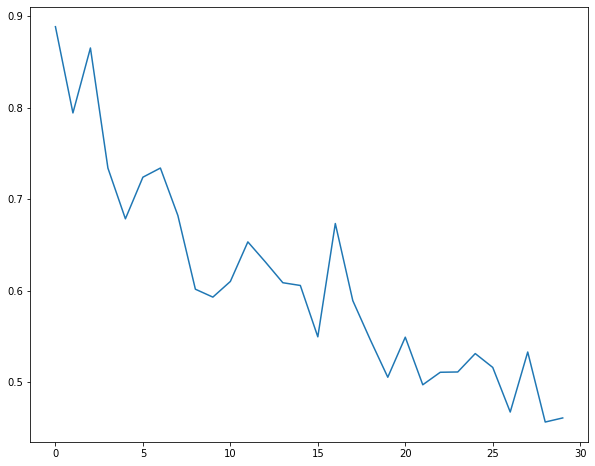

Epoch 1/100
24/24 - 3s - loss: 0.9472 - accuracy: 0.5273 - auc_23: 0.5393 - precision_23: 0.5342 - recall_23: 0.5410 - f1_score: 0.6736 - val_loss: 0.6714 - val_accuracy: 0.5807 - val_auc_23: 0.6356 - val_precision_23: 0.5511 - val_recall_23: 0.6739 - val_f1_score: 0.6479 - 3s/epoch - 107ms/step
Epoch 2/100
24/24 - 1s - loss: 0.8467 - accuracy: 0.5794 - auc_23: 0.5943 - precision_23: 0.5823 - recall_23: 0.6077 - f1_score: 0.6736 - val_loss: 0.6587 - val_accuracy: 0.6094 - val_auc_23: 0.6602 - val_precision_23: 0.5867 - val_recall_23: 0.6250 - val_f1_score: 0.6479 - 761ms/epoch - 32ms/step
Epoch 3/100
24/24 - 1s - loss: 0.7481 - accuracy: 0.5938 - auc_23: 0.6306 - precision_23: 0.5990 - recall_23: 0.6051 - f1_score: 0.6736 - val_loss: 0.8091 - val_accuracy: 0.5312 - val_auc_23: 0.6461 - val_precision_23: 0.8333 - val_recall_23: 0.0272 - val_f1_score: 0.6479 - 689ms/epoch - 29ms/step
Epoch 4/100
24/24 - 1s - loss: 0.7875 - accuracy: 0.6029 - auc_23: 0.6417 - precision_23: 0.6065 - recall

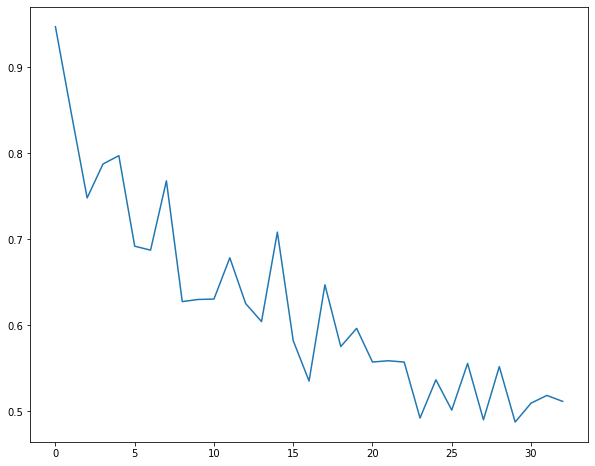

In [85]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs)
    history = rcnn_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_latefusion_model.save(model_path / 'late_binary_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion RCNN')

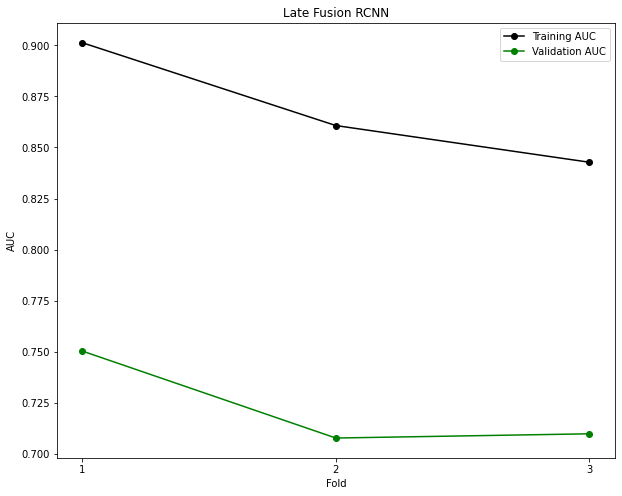

In [86]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion RCNN")

#### Training performance

In [87]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.7907986044883728,
 'ROC/AUC': 0.8682532707850138,
 'Precision': 0.785276194413503,
 'Recall': 0.7980028986930847,
 'F1-score': 0.6650837858517965}

In [88]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.0005655173603216213,
 'ROC/AUC': 0.0005991132390200783,
 'Precision': 0.00037361753230019055,
 'Recall': 0.001077894084922093,
 'F1-score': 5.05913937453152e-05}

#### Validation performance

In [89]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.671875,
 'ROC/AUC': 0.7226685682932535,
 'Precision': 0.6551597317059835,
 'Recall': 0.7277153333028158,
 'F1-score': 0.664970318476359}

In [90]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.000289351299957256,
 'ROC/AUC': 0.0003844826697406095,
 'Precision': 0.0003875603893403776,
 'Recall': 0.005241966829275037,
 'F1-score': 0.00020189955481065959}

#### Predictions and performance on test set

In [91]:
rcnn_binary_latefusion_model = load_model(model_path / 'late_binary_rcnn.h5')
y_pred = rcnn_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 8ms/step - loss: 0.8332 - accuracy: 0.5336 - auc_21: 0.6199 - precision_21: 0.9569 - recall_21: 0.4805 - f1_score: 0.9259
Accuracy: 53.36% 
ROC/AUC: 0.62 
Precision: 0.96 
Recall: 0.48 
F1 score: 0.93


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

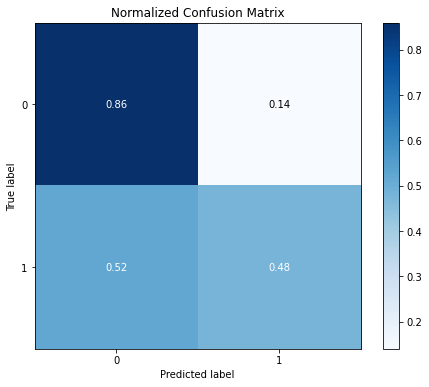

In [92]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

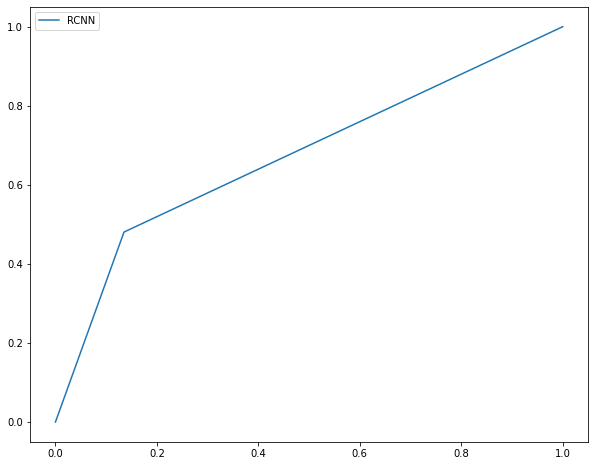

In [93]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

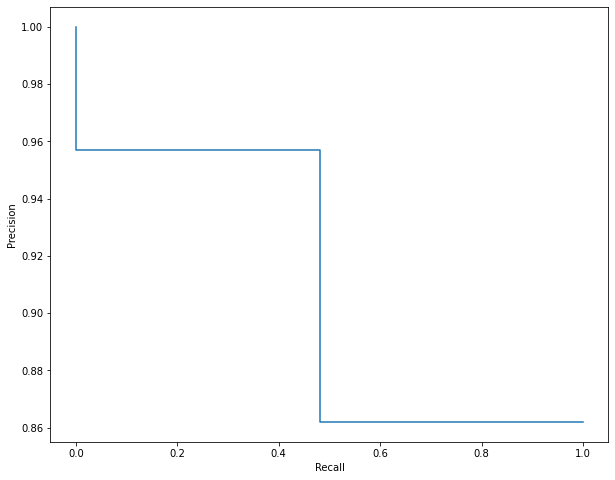

In [94]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.3 Ensemble

In [95]:
cnnlstm_body_member = KerasMember(name="CNN-BiLSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN-BiLSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [96]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [97]:
e = dirichletEnsemble.describe()

CNN-BiLSTM Body Model (weight: 0.6587)
RCNN Body Model (weight: 0.0899)
CNN-BiLSTM Face Model (weight: 0.2500)
RCNN Face Model (weight: 0.0014)
Accuracy: 100.00% - ROC/AUC: 0.71 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


## Results

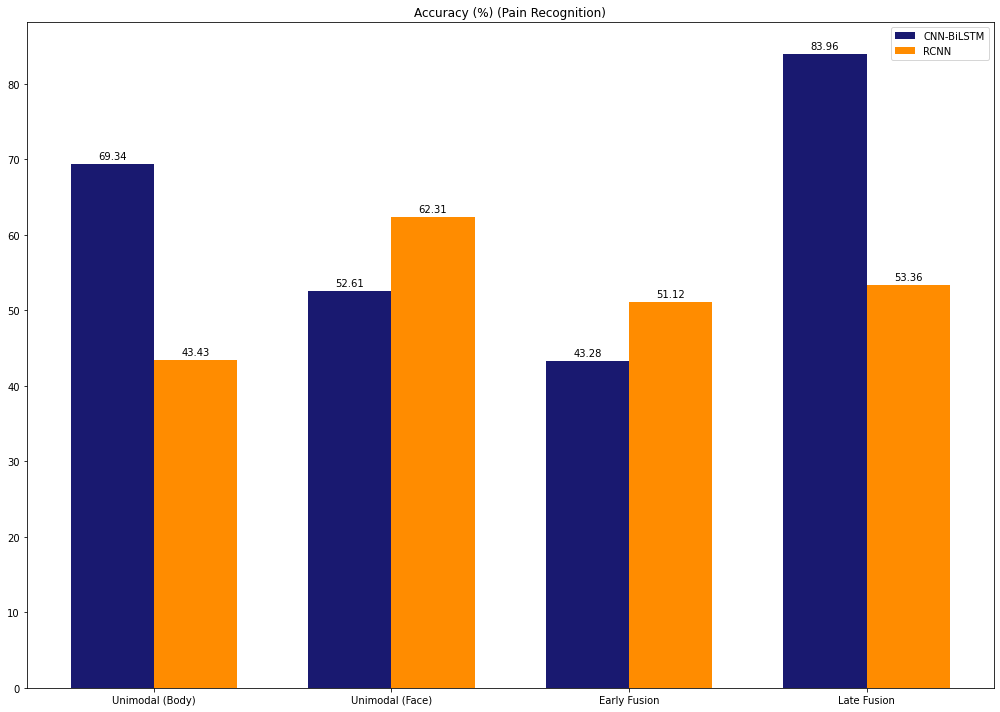

In [98]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_acc, width, label='CNN-BiLSTM', color='midnightblue')
rects2 = ax.bar(x + width/2, rcnn_acc, width, label='RCNN', color='darkorange')

ax.set_title('Accuracy (%) (Pain Recognition)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

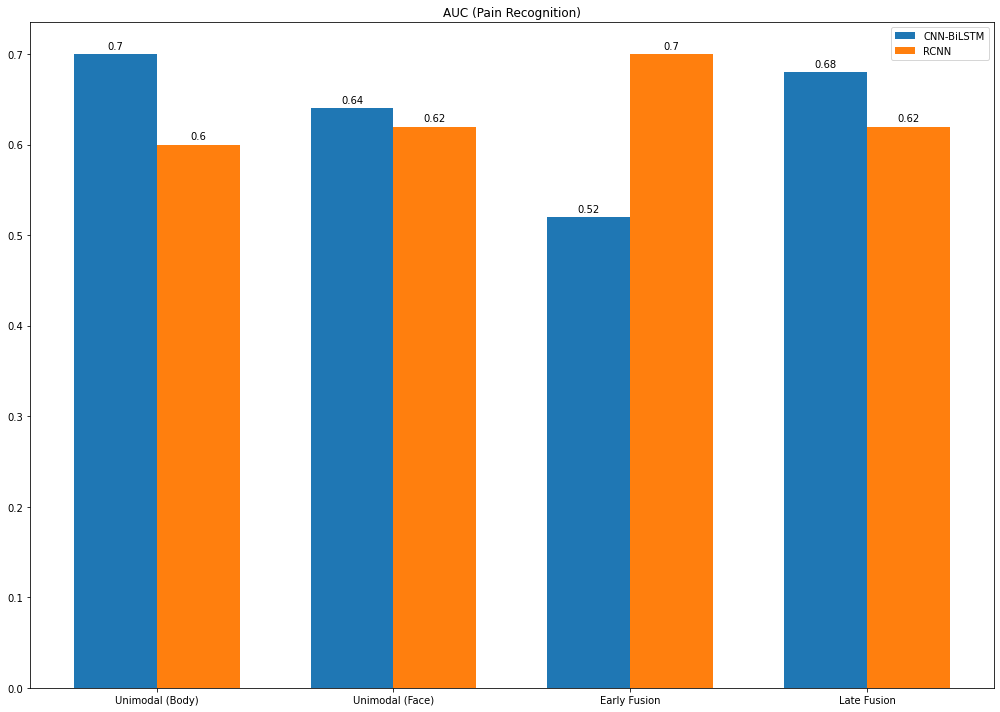

In [99]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN-BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('AUC (Pain Recognition)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()